# Code Update and compile
First, take the frontend of leonardo and test the connection.

In [ ]:
from BigDFT.Interop import RemoteManagerInterop as RM
sshpass='sshpass -P assphrase -f /tmp/leonardo'
leonardo_test=RM.get_computer(host='leonardo',sshpass_override=sshpass)
leonardo_test.test_connection()

Checking for entry point... Success (/leonardo/home/userexternal/lgenoves)
Checking file creation in home... True
Checking file creation in /tmp... 

This cell takes the current version of the code (branch `genovese`) and push it in the leonardo remote dir (branch `devel`)

In [6]:
remote_sourcedir='/leonardo/home/userexternal/lgenoves/bigdft-suite'
ls,lsd=RM.get_computer_specs(host='leonardo',action='update')
leonardo_frontend=RM.computer_from_specs(ls,**lsd)(sshpass_override=sshpass)
leonardo_frontend.update_resources(**RM.get_computer_resources(host='leonardo',flavour='frontend'))
#%pdb on
ds=RM.code_updater(url=leonardo_frontend,sourcedir='/opt/bigdft/sources/',
                   git='"' + sshpass + ' git"',
                   remote_sourcedir=remote_sourcedir,branch='genovese', remote_branch='devel')

Including git+ssh://leonardo//leonardo/home/userexternal/lgenoves/bigdft-suite as leonardo\n\nDelete remote target if non empty\n\nPushing external repo\n\nTo git+ssh://leonardo//leonardo/home/userexternal/lgenoves/bigdft-suite\n\n * [new branch]          genovese -> tmp_update\n


In [7]:
ds.run()

In [8]:
ds.fetch_results()
print(ds.results[0])
ds.hard_reset() # finish the update

 create mode 100644 bigdft/tests/DFT/linear/rotatesmall/old.xyz\n\n create mode 100644 bigdft/tests/DFT/linear/rotatesmall/old.yaml\n\n create mode 100644 bigdft/tests/DFT/linear/rotatesmall/rotatesmall_old.out.ref\n\n create mode 100644 bigdft/tests/DFT/linear/rotatesmall/rotatesmall_old.out.ref.yaml\n\n create mode 100644 chess/.gitrepo\n


This cell then creates the dataset for two different compilations of the code

In [19]:
#Get the builddirs from the installed paths
gnu=RM.get_computer_resources(host='leonardo',environment='1.9.4-gnu')
nvhpc=RM.get_computer_resources(host='leonardo',environment='1.9.4-nvhpc')
def get_prefix(res):
    return res['export'][0].replace('PREFIX=','')
def set_prefix(res, prefix):
    res['export'][0]='PREFIX='+prefix
base_dir='/leonardo/home/userexternal/lgenoves/binaries'
from os.path import join

In [20]:
leonardo=RM.get_computer(host='leonardo',flavour='gnu',sshpass_override=sshpass)
prefix=join(base_dir,'build-gnu')
set_prefix(gnu,prefix)
remote_compilation=RM.code_compiler(url=leonardo,
                                    builddir=prefix,
                                    prefix=get_prefix(gnu),
                                    sourcedir=remote_sourcedir,
                                    action="build" ,#'"buildone -f liborbs"',
                                    rcfile='/opt/bigdft/sources/rcfiles/leonardo-gnu.rc',
                                    builder='"$SOURCEDIR/Installer.py -y"'
                                   )

appended run runner-0


In [21]:
remote_compilation.run()

assessing run for runner compile_code_rm-794eb9ce-runner-0... running


In [25]:
# and then the nvhpc compilation
prefix=join(base_dir,'build-nvhpc')
set_prefix(nvhpc,prefix)
remote_compilation.append_run(remote_dir=join(base_dir,'build-nvhpc'),
                              prefix=get_prefix(nvhpc),
                              rcfile='leonardo.rc',
                              extra_files_send=['/opt/bigdft/sources/rcfiles/leonardo.rc'],
                              **RM.get_computer_resources(host='leonardo',flavour='nvhpc'))

appended run runner-1


In [26]:
remote_compilation.run()

assessing run for runner compile_code_rm-794eb9ce-runner-0... skipping already submitted run
assessing run for runner compile_code_rm-794eb9ce-runner-1... running


# Run of the first bench
We take an example (without the usage of GPU) from the 2CzPn calculations

In [39]:
from json import load
from copy import deepcopy
from os.path import join
with open('leonardo_bench.json') as ifile:
    base_bench = list(load(ifile))

In [40]:
from remotemanager import Dataset
from BigDFT.Interop import RemoteManagerInterop as RM
from BigDFT import Inputfiles as I
sshpass='sshpass -P assphrase -f /tmp/leonardo'
base_dir='/leonardo/home/userexternal/lgenoves/binaries'
remote_gnu='/leonardo/home/userexternal/lgenoves/benchs/2CzPN-gnu'
#remote_nvhpc='/leonardo_work/Max3_devel_2/bigdft/2CzPN-nvhpc'
leonardo=RM.get_computer(host='leonardo',flavour='gnu',environment='1.9.4-gnu',sshpass_override=sshpass)
prefix=join(base_dir,'build-gnu')
leonardo.export.value[0]='PREFIX='+prefix
# we first pile up the gnu calculations
from benchmark import run_bigdft
ds=Dataset(run_bigdft,local_dir='leonardo-2CzPN-gnu',
           dbfile='leonardo-2CzPN-gnu.yaml',
           remote_dir=remote_gnu,
           name='2CzPN',url=leonardo, time='02:00:00',skip=False)
bench=[t for t in base_bench.copy() if t['mpi']*t['omp']<=64 ]
for run in bench:
    ds.append_run(lazy=True,**run.copy())
for run in bench:
    run=deepcopy(run)
    inp=I.Inputfile(run['arguments']['input'])
    inp.use_gpu_acceleration(flavour='OCL')
    run['arguments']['input'] = dict(inp)
    run['arguments']['name'] += '-ocl'
    run['gpu'] = 4
    run['name'] += '-ocl'
    ds.append_run(lazy=True,**run.copy())
for run in bench:
    run=deepcopy(run)
    inp=I.Inputfile(run['arguments']['input'])
    inp.set_xc('PBE0')
    run['arguments']['input'] = dict(inp)
    run['arguments']['name'] += '-pbe0'
    run['name'] += '-pbe0'    
    ds.append_run(lazy=True,**run.copy())
for run in bench:
    run=deepcopy(run)
    inp=I.Inputfile(run['arguments']['input'])
    inp.set_xc('PBE0')
    inp.use_gpu_acceleration(flavour='CUDA')
    run['arguments']['input'] = dict(inp)
    run['arguments']['name'] += '-pbe0-cuda'
    run['gpu'] = 4
    run['name'] += '-pbe0-cuda'
    ds.append_run(lazy=True,**run.copy())
for run in bench:
    run=deepcopy(run)
    inp=I.Inputfile(run['arguments']['input'])
    inp.set_xc('PBE0')
    inp.use_gpu_acceleration(flavour='OCL')
    run['arguments']['input'] = dict(inp)
    run['arguments']['name'] += '-pbe0-ocl'    
    run['gpu'] = 4
    run['name'] += '-pbe0-ocl'
    ds.append_run(lazy=True,**run.copy())    
# # then we may even pile up the nvhpc calculations
# nvhpc_run=RM.get_computer_resources(host='leonardo',environment='1.9.4-nvhpc',flavour='nvhpc')
# for run in bench:
#     ds.append_run(lazy=True,remote_dir=remote_nvhpc, **run, **nvhpc_run)
ds.finish_append()

Of 24 appends: 24 added. See run_log for more info


In [42]:
ds.run()

assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-16-1-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-32-1-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-64-1-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-8-2-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-16-2-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-32-2-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-4-4-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-8-4-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-16-4-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-2-8-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-4-8-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-8-8-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_2.pdb-32-1-pbe0... running
assessing run for runner 2CzPN-0e829193-2CzPN_2.pdb-64-1-

In [6]:
ds.fetch_results()

In [12]:
base_bench[0]['extra_files_recv']

['2CzPN_1.pdb-16-1.tar.gz']

# Analyze the bench results

In [9]:
import benchmark
df=benchmark.dataframe(benchmark.extract_results(directory='leonardo-2CzPN-gnu'))

In [10]:
pbe=df[~df['name'].str.endswith(('ocl','cuda','pbe0'))].sort_values(['Nat','cores','OMP'])

In [11]:
pbe_ocl=df[df['name'].str.endswith(('ocl')) * ~df['name'].str.contains('pbe0')].sort_values(['Nat','cores','OMP'])

In [12]:
pbe0=df[df['name'].str.contains('pbe0')* ~df['name'].str.contains('pbe0-ocl')* ~df['name'].str.contains('pbe0-cuda') ].sort_values(['Nat','cores','OMP'])

In [13]:
pbe0_cuda=df[df['name'].str.contains('pbe0-cuda')* ~df['name'].str.contains('pbe0-ocl') ].sort_values(['Nat','cores','OMP'])

In [14]:
def get_lookup(dst, src, idx, spec):
    lookup = True
    for s in spec:
        lookup *= dst[s] == src[s][idx]
    return lookup
def get_df_lookup(of,with_respect_to,spec=['OMP','cores','Nat']):
    from itertools import product
    from numpy import array
    from pandas import concat
    xs = []
    lups = []
    for ipiv,idx in enumerate(with_respect_to.index):
        lookup = get_lookup(dst=of, src=with_respect_to, idx=idx,spec=spec)
        ys = [i for i, v in enumerate(lookup) if v]
        if len(ys) == 0:
            continue
        assert len(ys) == 1, 'Multiple calculations in data: '+str(of[lookup].index)
        xs.append(ipiv)
        lups.append(of[lookup])
    return xs,concat(lups)
def get_timedata(df,reference=None,spec=['OMP','cores','Nat'],
                 widgets=False,only_last=True, **kwargs):
    from futile.Time import TimeData
    if reference is None:
        dft = df
    else:
        dft = get_df_lookup(of=df,with_respect_to=reference, spec=spec)        
    return TimeData(*dft['timefile'],widgets=widgets,only_last=only_last, **kwargs)

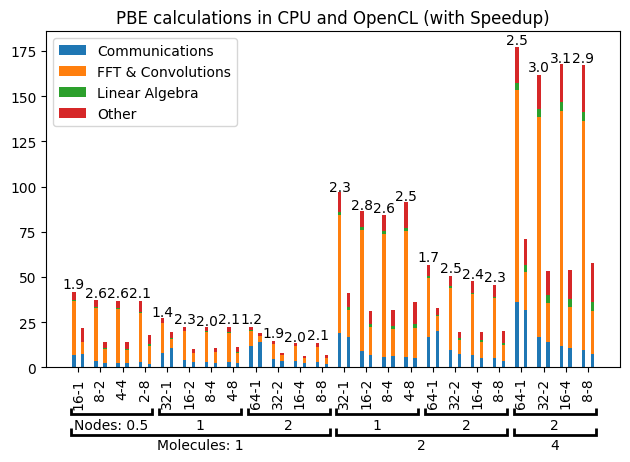

In [15]:
aggregate=[('Communications',['Communications']),
           ('FFT & Convolutions',['Convolutions','PS Computation','Potential']),
           ('Linear Algebra',['BLAS-LAPACK', 'Linear Algebra']),
           ('Other',['Flib LowLevel','Unknown', 'Other'])]
tt=get_timedata(pbe_ocl)
ax=benchmark.draw_barplot(tt.ids,tt.actual_data,
                          aggregate=aggregate,
                          #annotations=pbe_ocl['Nat']/54,
                          shift=+0.2,width=0.15)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.legend(loc='best')
xs,dft=get_df_lookup(pbe,with_respect_to=pbe_ocl)
tt=get_timedata(dft)
speedup=[round(s,1) for s in ((dft['WFN_OPT'].to_numpy())/(pbe_ocl['WFN_OPT'].to_numpy()[xs])).flatten()]
ax=benchmark.draw_barplot(tt.ids,tt.actual_data,x=xs,
                          annotations=speedup,
                          aggregate=aggregate,
                          ax=ax,shift=-0.2,width=0.15)
spine_pos=-0.14
tip_pos=-0.12
extra_off = 0.35
for start,end,label in [(0,3,'Nodes: 0.5'),
                        (4,7,'1'),
                        (8,11,'2'),
                        (12,15,'1'),
                        (16,19,'2'),
                        (20,23,'2')]:
    benchmark.add_label_band(ax, 'x', start-extra_off, end+extra_off, label,
                   spine_pos=spine_pos,tip_pos=tip_pos)
spine_pos=-0.2
tip_pos=-0.18
for start,end,label in [(0,11,'Molecules: 1'),
                        (12,19,'2'),
                        (20,23,'4')]:
    benchmark.add_label_band(ax, 'x', start-extra_off, end+extra_off, label,
                   spine_pos=spine_pos,tip_pos=tip_pos)    
ax.set_title('PBE calculations in CPU and OpenCL (with Speedup)')
ax.get_figure().tight_layout()

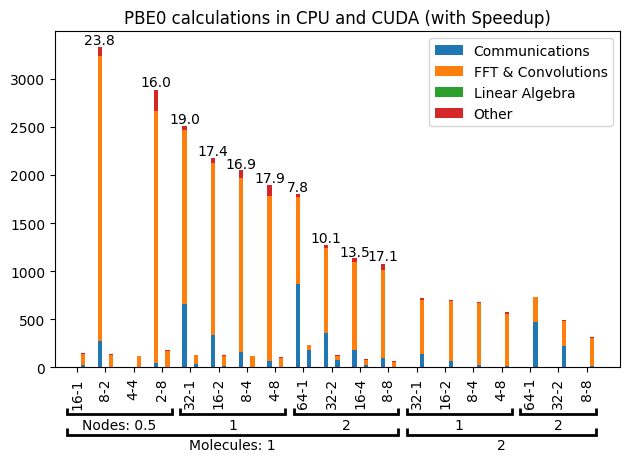

In [16]:
tt=get_timedata(pbe0_cuda)
ax=benchmark.draw_barplot(tt.ids,tt.actual_data,
                          aggregate=aggregate,
                          #annotations=pbe0_cuda['Nat']/54,
                          shift=+0.2,width=0.15)
labels=tt.ids
ax.legend(loc='best')
xs,dft=get_df_lookup(pbe0,with_respect_to=pbe0_cuda)
tt=get_timedata(dft)
speedup=[round(s,1) for s in ((dft['WFN_OPT'].to_numpy())/(pbe0_cuda['WFN_OPT'].to_numpy()[xs])).flatten()]
ax=benchmark.draw_barplot(tt.ids,tt.actual_data,x=xs,
                          annotations=speedup,
                          aggregate=aggregate,
                          ax=ax,shift=-0.2,width=0.15)
spine_pos=-0.14
tip_pos=-0.12
extra_off = 0.35
for start,end,label in [(0,3,'Nodes: 0.5'),
                        (4,7,'1'),
                        (8,11,'2'),
                        (12,15,'1'),
                        (16,18,'2')]:
    benchmark.add_label_band(ax, 'x', start-extra_off, end+extra_off, label,
                   spine_pos=spine_pos,tip_pos=tip_pos)
spine_pos=-0.2
tip_pos=-0.18
for start,end,label in [(0,11,'Molecules: 1'),
                        (12,18,'2')]:
    benchmark.add_label_band(ax, 'x', start-extra_off, end+extra_off, label,
                   spine_pos=spine_pos,tip_pos=tip_pos)    
ax.set_xticks(range(len(labels)),labels,rotation=90)
ax.set_title('PBE0 calculations in CPU and CUDA (with Speedup)')
ax.get_figure().tight_layout()

In [18]:
#total amount of hours for the benchmark
df['CPUhours'].sum()

421.78844741025773